# Acceleration sites r= 10000


In [1]:
#function for the simulation
import numpy as np
from numba import jit, prange
from numba.typed import List
import matplotlib.pyplot as plt
# ============================================================================
# INITIALIZATION FUNCTIONS
# ============================================================================
@jit(nopython=True)
def initialize_flat(width, height):
    """Initialize with flat bottom row."""
    lattice = np.zeros((height, width), dtype=np.int32)
    lattice[-1, :] = 1
    return lattice
@jit(nopython=True)
def initialize_rough(width, height, roughness_height, seed=None):
    """Initialize with random roughness on top of bottom row."""
    if seed is not None:
        np.random.seed(seed)
    lattice = np.zeros((height, width), dtype=np.int32)
    for j in range(width):
        h = np.random.randint(1, roughness_height + 1)
        for i in range(height - h, height):
            lattice[i, j] = 1
    return lattice
# ============================================================================
# CLUSTER PLACEMENT WITH RUGOSITY CONTROL
# ============================================================================
import numpy as np
from numba import jit, int32, njit, prange, types
from numba.typed import List, Dict


@njit(parallel=True)
def place_eden_clusters(width, height, avg_cluster_size, probability, lattice, seed=None):
    """Place acceleration clusters using small Eden growth."""
    if seed is not None:
        np.random.seed(seed)
    acc_sites = np.zeros((height, width), dtype=np.int32)
    cluster_labels = np.zeros((height, width), dtype=np.int32)
    cluster_id = 1
    max_cluster_size = avg_cluster_size * 10
    # Verwende ein großes Array statt Liste von Arrays
    max_total_sites = height * width
    all_cluster_positions = np.zeros((max_total_sites, 2), dtype=np.int32)
    cluster_starts = np.zeros(max_total_sites, dtype=np.int32)
    cluster_sizes = np.zeros(max_total_sites, dtype=np.int32)
    current_position = 0
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                # Speichere Start-Position für diesen Cluster
                cluster_starts[cluster_id] = current_position
                # Temporäre Arrays für Cluster-Wachstum
                cluster_positions = np.zeros((max_cluster_size, 2), dtype=np.int32)
                cluster_positions[0, 0] = i
                cluster_positions[0, 1] = j
                acc_sites[i, j] = 1
                cluster_labels[i, j] = cluster_id
                placed = 1
                # Perimeter für Eden growth
                perimeter = np.zeros((max_cluster_size * 4, 2), dtype=np.int32)
                perimeter_size = 0
                perimeter_set = np.zeros((height, width), dtype=np.int32)
                # Initialisiere perimeter mit Nachbarn des seed
                for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                    ni = i + di
                    nj = (j + dj) % width  # Periodic BC horizontal
                    if 0 <= ni < height:  # No periodic in vertical
                        if acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0 and perimeter_set[ni, nj] == 0:
                            perimeter[perimeter_size, 0] = ni
                            perimeter[perimeter_size, 1] = nj
                            perimeter_set[ni, nj] = 1
                            perimeter_size += 1
                # Eden growth
                while placed < cluster_size and perimeter_size > 0:
                    # Wähle zufälligen perimeter site
                    idx = np.random.randint(perimeter_size)
                    ni, nj = perimeter[idx, 0], perimeter[idx, 1]
                    # Füge zur cluster hinzu
                    acc_sites[ni, nj] = 1
                    cluster_labels[ni, nj] = cluster_id
                    cluster_positions[placed, 0] = ni
                    cluster_positions[placed, 1] = nj
                    placed += 1
                    # Entferne aus perimeter (swap mit letztem Element)
                    perimeter_set[ni, nj] = 0
                    perimeter[idx] = perimeter[perimeter_size - 1]
                    perimeter_size -= 1
                    # Füge neue Nachbarn zum perimeter hinzu
                    for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                        nni = ni + di
                        nnj = (nj + dj) % width  # Periodic BC horizontal
                        if 0 <= nni < height:
                            if acc_sites[nni, nnj] == 0 and lattice[nni, nnj] == 0 and perimeter_set[nni, nnj] == 0:
                                if perimeter_size < max_cluster_size * 4:
                                    perimeter[perimeter_size, 0] = nni
                                    perimeter[perimeter_size, 1] = nnj
                                    perimeter_set[nni, nnj] = 1
                                    perimeter_size += 1
                # Speichere Cluster-Positionen im großen Array
                for p in range(placed):
                    all_cluster_positions[current_position + p] = cluster_positions[p]
                cluster_sizes[cluster_id] = placed
                current_position += placed
                cluster_id += 1
    # Merge adjacent clusters - VEREINFACHT und SCHNELLER
    num_clusters = cluster_id
    if num_clusters > 1:
        parent = np.arange(num_clusters, dtype=np.int32)
        # Union-Find mit Path-Kompression direkt
        def find_root(p, x):
            root = x
            while p[root] != root:
                root = p[root]
            # Path compression
            while x != root:
                next_x = p[x]
                p[x] = root
                x = next_x
            return root
        # Union-Find
        for i in range(height):
            for j in range(width):
                if acc_sites[i, j]:
                    label = cluster_labels[i, j]
                    # Check right with periodic
                    nj_right = (j + 1) % width
                    if acc_sites[i, nj_right]:
                        n_label = cluster_labels[i, nj_right]
                        if n_label != label:
                            root1 = find_root(parent, label)
                            root2 = find_root(parent, n_label)
                            if root1 != root2:
                                parent[root1] = root2
                    # Check down (no periodic vertical)
                    if i + 1 < height and acc_sites[i + 1, j]:
                        n_label = cluster_labels[i + 1, j]
                        if n_label != label:
                            root1 = find_root(parent, label)
                            root2 = find_root(parent, n_label)
                            if root1 != root2:
                                parent[root1] = root2
        # Final path compression für alle
        for c in prange(1, num_clusters):
            find_root(parent, c)
        # Zähle unique roots und erstelle Mapping
        is_root = np.zeros(num_clusters, dtype=np.int32)
        for c in range(1, num_clusters):
            is_root[parent[c]] = 1
        new_id_map = np.zeros(num_clusters, dtype=np.int32)
        new_id = 1
        for c in range(1, num_clusters):
            if is_root[c]:
                new_id_map[c] = new_id
                new_id += 1
        num_new_clusters = new_id
        # Update cluster_labels parallel
        for i in prange(height):
            for j in range(width):
                if cluster_labels[i, j] > 0:
                    root = parent[cluster_labels[i, j]]
                    cluster_labels[i, j] = new_id_map[root]
        # Berechne neue Cluster-Größen
        new_cluster_sizes = np.zeros(num_new_clusters, dtype=np.int32)
        for c in range(1, num_clusters):
            root = parent[c]
            new_id = new_id_map[root]
            new_cluster_sizes[new_id] += cluster_sizes[c]
        # Berechne neue Start-Positionen
        new_starts = np.zeros(num_new_clusters, dtype=np.int32)
        cumsum = 0
        for nid in range(1, num_new_clusters):
            new_starts[nid] = cumsum
            cumsum += new_cluster_sizes[nid]
        # Erstelle neue Positions-Array
        new_all_positions = np.zeros((cumsum, 2), dtype=np.int32)
        position_counter = np.zeros(num_new_clusters, dtype=np.int32)
        # Fülle neue Positionen
        for c in range(1, num_clusters):
            root = parent[c]
            new_id = new_id_map[root]
            start = cluster_starts[c]
            size = cluster_sizes[c]
            dest_idx = new_starts[new_id] + position_counter[new_id]
            for p in range(size):
                new_all_positions[dest_idx + p] = all_cluster_positions[start + p]
            position_counter[new_id] += size
        return acc_sites, cluster_labels, new_all_positions, new_starts, new_cluster_sizes
    else:
        return (acc_sites, cluster_labels,
                all_cluster_positions[:current_position],
                cluster_starts[:num_clusters],
                cluster_sizes[:num_clusters])
# Wrapper-Funktion um die alte API zu behalten
def place_eden_clusters_with_list(width, height, avg_cluster_size, probability, lattice, seed=None):
    """Wrapper that returns cluster_list as a list of arrays like the original."""
    acc_sites, cluster_labels, all_positions, starts, sizes = place_eden_clusters(
        width, height, avg_cluster_size, probability, lattice, seed
    )
    # Konvertiere zurück zu Liste von Arrays
    cluster_list = [np.zeros((0, 2), dtype=np.int32)] # Dummy
    for i in range(1, len(starts)):
        start = starts[i]
        size = sizes[i]
        cluster_array = all_positions[start:start+size].copy()
        cluster_list.append(cluster_array)
    return acc_sites, cluster_labels, cluster_list
@jit(nopython=True)
def place_clusters_with_labels(width, height, avg_cluster_size, probability, lattice, seed=None):
    """Place clusters and label each site with its cluster ID. Tune roughness with rugosity (0=smooth, 1=rough)."""
    if seed is not None:
        np.random.seed(seed)
    acc_sites = np.zeros((height, width), dtype=np.int32)
    cluster_labels = np.zeros((height, width), dtype=np.int32)
    cluster_list = List()
    cluster_list.append(np.zeros((0, 2), dtype=np.int32)) # Dummy for cluster 0
    cluster_id = 1
    max_cluster_size = avg_cluster_size * 10
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                cluster_positions = np.zeros((max_cluster_size, 2), dtype=np.int32)
                cluster_positions[0, 0] = i
                cluster_positions[0, 1] = j
                acc_sites[i, j] = 1
                cluster_labels[i, j] = cluster_id
                placed = 1
                # Track all cluster sites for random selection
                cluster_i = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_j = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_i[0] = i
                cluster_j[0] = j
                cluster_count = 1
                attempts=0
                boundary_count=1
                center_i=float(i)
                center_j=float(j)
                max_attempts = cluster_size * 10
                while placed < cluster_size and attempts < max_attempts and boundary_count > 0:
                    attempts += 1
                    # ROUGH MODE: Pick random cluster site, add random neighbor (original behavior)
                    idx = np.random.randint(0, cluster_count)
                    ci = cluster_i[idx]
                    cj = cluster_j[idx]
                    neighbor_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                    neighbor_j = np.array([cj, cj, cj-1, cj+1], dtype=np.int32)
                    available = np.zeros(4, dtype=np.int32)
                    n_available = 0
                    for n_idx in range(4):
                        ni = neighbor_i[n_idx]
                        nj = (neighbor_j[n_idx]) % width  # Periodic BC horizontal
                        if 0 <= ni < height and acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0:
                            available[n_available] = n_idx
                            n_available += 1
                    if n_available > 0:
                        pick = np.random.randint(0, n_available)
                        n_idx = available[pick]
                        ni = neighbor_i[n_idx]
                        nj = (neighbor_j[n_idx]) % width
                        acc_sites[ni, nj] = 1
                        cluster_labels[ni, nj] = cluster_id
                        cluster_positions[placed, 0] = ni
                        cluster_positions[placed, 1] = nj
                        cluster_i[cluster_count] = ni
                        cluster_j[cluster_count] = nj
                        cluster_count += 1
                        boundary_count += 1
                        placed += 1
                        # Update center
                        center_i = (center_i * (placed - 1) + ni) / placed
                        center_j = (center_j * (placed - 1) + nj) / placed
                        # (No boundary removal in rough mode for simplicity)
                cluster_positions_actual = cluster_positions[:placed].copy()
                cluster_list.append(cluster_positions_actual)
                cluster_id += 1
    if cluster_id > 1:
        parent = np.arange(cluster_id, dtype=np.int32)
        rank = np.zeros(cluster_id, dtype=np.int32)
        def find(x):
            root = x
            while parent[root] != root:
                root = parent[root]
            # Compress path
            while x != root:
                nxt = parent[x]
                parent[x] = root
                x = nxt
            return root
        def union(x, y):
            px = find(x)
            py = find(y)
            if px != py:
                if rank[px] > rank[py]:
                    parent[py] = px
                elif rank[px] < rank[py]:
                    parent[px] = py
                else:
                    parent[py] = px
                    rank[px] += 1
        # Find touching clusters with periodic right
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    # Check right with periodic
                    nj_right = (jj + 1) % width
                    if cluster_labels[ii, nj_right] > 0 and cluster_labels[ii, jj] != cluster_labels[ii, nj_right]:
                        union(cluster_labels[ii, jj], cluster_labels[ii, nj_right])
                    # Check down (no periodic)
                    if ii + 1 < height and cluster_labels[ii + 1, jj] > 0 and cluster_labels[ii, jj] != cluster_labels[ii + 1, jj]:
                        union(cluster_labels[ii, jj], cluster_labels[ii + 1, jj])
        # Path compression
        for k in range(1, cluster_id):
            parent[k] = find(k)
        # Update cluster_labels to root parents
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    cluster_labels[ii, jj] = parent[cluster_labels[ii, jj]]
        # Find unique merged labels and remap to consecutive IDs
        has_label = np.zeros(cluster_id, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    has_label[lbl] = 1
        new_num_clusters = 0
        label_map = np.zeros(cluster_id, dtype=np.int32)
        for lbl in range(1, cluster_id):
            if has_label[lbl] == 1:
                new_num_clusters += 1
                label_map[lbl] = new_num_clusters
        # Remap labels
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    cluster_labels[ii, jj] = label_map[cluster_labels[ii, jj]]
        # Count sizes for new clusters
        sizes = np.zeros(new_num_clusters + 1, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    sizes[lbl] += 1
        # Rebuild cluster_list
        new_cluster_list = List()
        new_cluster_list.append(np.zeros((0, 2), dtype=np.int32))
        counters = np.zeros(new_num_clusters + 1, dtype=np.int32)
        for new_id in range(1, new_num_clusters + 1):
            pos = np.zeros((sizes[new_id], 2), dtype=np.int32)
            new_cluster_list.append(pos)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    pos = new_cluster_list[lbl]
                    idx = counters[lbl]
                    pos[idx, 0] = ii
                    pos[idx, 1] = jj
                    counters[lbl] += 1
        cluster_list = new_cluster_list
    return acc_sites, cluster_labels, cluster_list
@jit(nopython=True)
def place_constraint_clusters(width, height, avg_cluster_size, probability, lattice, acc_sites, seed=None):
    """Place constraint clusters."""
    if seed is not None:
        np.random.seed(seed)
    con_sites = np.zeros((height, width), dtype=np.int32)
    max_cluster_size = avg_cluster_size * 10
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and con_sites[i, j] == 0 and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                placed = 1
                con_sites[i, j] = 1
                cluster_i = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_j = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_i[0] = i
                cluster_j[0] = j
                cluster_count = 1
                attempts = 0
                max_attempts = cluster_size * 10
                while placed < cluster_size and attempts < max_attempts:
                    idx = np.random.randint(0, cluster_count)
                    ci = cluster_i[idx]
                    cj = cluster_j[idx]
                    neighbor_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                    neighbor_j = np.array([cj, cj, cj-1, cj+1], dtype=np.int32)
                    available = np.zeros(4, dtype=np.int32)
                    n_available = 0
                    for n_idx in range(4):
                        ni = neighbor_i[n_idx]
                        nj = (neighbor_j[n_idx]) % width  # Periodic BC horizontal
                        if 0 <= ni < height and con_sites[ni, nj] == 0 and acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0:
                            available[n_available] = n_idx
                            n_available += 1
                    if n_available > 0:
                        pick = np.random.randint(0, n_available)
                        n_idx = available[pick]
                        ni = neighbor_i[n_idx]
                        nj = (neighbor_j[n_idx]) % width
                        con_sites[ni, nj] = 1
                        cluster_i[cluster_count] = ni
                        cluster_j[cluster_count] = nj
                        cluster_count += 1
                        placed += 1
                    attempts += 1
    return con_sites
# ============================================================================
# HELPER: Extract interface heights
# ============================================================================
@jit(nopython=True)
def extract_interface_heights(lattice, width, height):
    """Extract the height of the topmost occupied cell in each column."""
    heights = np.zeros(width, dtype=np.int32)
    for j in range(width):
        for i in range(height):
            if lattice[i, j] == 1:
                heights[j] = height - i
                break
    return heights
# ============================================================================
# EDEN MODEL WITH CASCADES AND SNAPSHOTS
# ============================================================================
@jit(nopython=True)
def eden_model_cascade_with_snapshots(width, height, n_iterations, snapshot_times,
                                      avg_cluster_size=5, probability=0.01,
                                      acceleration_factor=2.0, init_mode='flat',
                                      roughness_height=5,
                                      constraint_prob=0.0,
                                      constraint_avg_cluster_size=5,
                                      seed=None, eden_sites=False):
    """
    Eden Model with cascades and time-resolved snapshots.
    Parameters:
    -----------
    acc_rugosity : float
        Controls surface roughness of acceleration clusters (0.0 = smooth, 1.0 = rough)
    Returns:
    --------
    lattice : numpy.ndarray
        Final lattice (height, width)
    acc_sites : numpy.ndarray
        Acceleration sites (height, width)
    con_sites : numpy.ndarray
        Constraint sites (height, width)
    snapshots : numpy.ndarray
        Interface heights at snapshot times (n_snapshots, width)
    density : float
        Density of constraint clusters in the grown zone
    """
    if seed is not None:
        np.random.seed(seed)
    # Initialize lattice
    if init_mode == 'rough':
        lattice = initialize_rough(width, height, roughness_height, seed)
    else:
        lattice = initialize_flat(width, height)
    # Place clusters with rugosity control
    acc_sites, cluster_labels, cluster_list = place_clusters_with_labels(
        width, height, avg_cluster_size, probability, lattice, seed
    )
    if eden_sites == True:
        acc_sites, cluster_labels, all_positions, starts, sizes = place_eden_clusters(
            width, height, avg_cluster_size, probability, lattice, seed
        )
        # Build cluster_list from cluster_labels inside Numba
        max_label = 0
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > max_label:
                    max_label = lbl
        cluster_sizes = np.zeros(max_label + 1, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    cluster_sizes[lbl] += 1
        cluster_list = List()
        cluster_list.append(np.zeros((0, 2), dtype=np.int32))
        for lbl in range(1, max_label + 1):
            if cluster_sizes[lbl] > 0:
                pos = np.zeros((cluster_sizes[lbl], 2), dtype=np.int32)
                cluster_list.append(pos)
        counters = np.zeros(max_label + 1, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    pos = cluster_list[lbl]
                    idx = counters[lbl]
                    pos[idx, 0] = ii
                    pos[idx, 1] = jj
                    counters[lbl] += 1
    else:
        acc_sites, cluster_labels, cluster_list = place_clusters_with_labels(
            width, height, avg_cluster_size, probability, lattice, seed)
    con_sites = place_constraint_clusters(
        width, height, constraint_avg_cluster_size, constraint_prob, lattice, acc_sites, seed
    )
    n_clusters = len(cluster_list)
    cluster_activated = np.zeros(n_clusters, dtype=np.int32)
    # Initialize boundaries
    is_boundary = np.zeros((height, width), dtype=np.int32)
    max_boundary_size = width * height
    boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_count = 0
    acc_boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_cluster = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_count = 0
    # Find initial boundaries with periodic horizontal
    for i in range(height):
        for j in range(width):
            if lattice[i, j] == 0 and con_sites[i, j] == 0:
                has_occupied = False
                # Check up (no periodic vertical)
                if i > 0 and lattice[i-1, j] == 1:
                    has_occupied = True
                # Check down
                if i < height-1 and lattice[i+1, j] == 1:
                    has_occupied = True
                # Check left with periodic
                nj_left = (j - 1) % width
                if lattice[i, nj_left] == 1:
                    has_occupied = True
                # Check right with periodic
                nj_right = (j + 1) % width
                if lattice[i, nj_right] == 1:
                    has_occupied = True
                if has_occupied:
                    is_boundary[i, j] = 1
                    cell_cluster = cluster_labels[i, j]
                    if cell_cluster > 0 and cluster_activated[cell_cluster] == 0:
                        already_in = False
                        for k in range(acc_boundary_count):
                            if acc_boundary_cluster[k] == cell_cluster:
                                already_in = True
                                break
                        if not already_in:
                            acc_boundary_i[acc_boundary_count] = i
                            acc_boundary_j[acc_boundary_count] = j
                            acc_boundary_cluster[acc_boundary_count] = cell_cluster
                            acc_boundary_count += 1
                    else:
                        boundary_i[boundary_count] = i
                        boundary_j[boundary_count] = j
                        boundary_count += 1
    # Pre-allocate snapshots
    n_snapshots = len(snapshot_times)
    snapshots = np.zeros((n_snapshots, width), dtype=np.int32)
    snapshot_idx = 0
    # Growth iterations with snapshot capture
    for iteration in range(n_iterations):
        # Capture snapshot at the right time
        if snapshot_idx < n_snapshots and iteration == snapshot_times[snapshot_idx]:
            snapshots[snapshot_idx] = extract_interface_heights(lattice, width, height)
            snapshot_idx += 1
        total_boundary = boundary_count + acc_boundary_count
        if total_boundary == 0:
            break
        total_weight = boundary_count + acc_boundary_count * acceleration_factor
        rand_val = np.random.random() * total_weight
        if rand_val < acc_boundary_count * acceleration_factor and acc_boundary_count > 0:
            # CASCADE: Select acceleration cluster
            idx = np.random.randint(0, acc_boundary_count)
            selected_cluster = acc_boundary_cluster[idx]
            cluster_sites = cluster_list[selected_cluster]
            # Occupy entire cluster
            for k in range(len(cluster_sites)):
                ci, cj = cluster_sites[k, 0], cluster_sites[k, 1]
                lattice[ci, cj] = 1
                is_boundary[ci, cj] = 0
            cluster_activated[selected_cluster] = 1
            acc_boundary_count -= 1
            if idx < acc_boundary_count:
                acc_boundary_i[idx] = acc_boundary_i[acc_boundary_count]
                acc_boundary_j[idx] = acc_boundary_j[acc_boundary_count]
                acc_boundary_cluster[idx] = acc_boundary_cluster[acc_boundary_count]
            # Add neighbors of all cluster sites with periodic horizontal
            for k in range(len(cluster_sites)):
                ci, cj = cluster_sites[k, 0], cluster_sites[k, 1]
                neighbors_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                neighbors_j = np.array([cj, cj, (cj-1)%width, (cj+1)%width], dtype=np.int32)
                for n_idx in range(4):
                    ni = neighbors_i[n_idx]
                    nj = neighbors_j[n_idx]
                    if 0 <= ni < height:
                        if lattice[ni, nj] == 0 and con_sites[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                            has_occ = (ni > 0 and lattice[ni-1, nj] == 1) or \
                                       (ni < height-1 and lattice[ni+1, nj] == 1) or \
                                       lattice[ni, (nj-1)%width] == 1 or \
                                       lattice[ni, (nj+1)%width] == 1
                            if has_occ:
                                is_boundary[ni, nj] = 1
                                nc = cluster_labels[ni, nj]
                                if nc > 0 and cluster_activated[nc] == 0:
                                    already = False
                                    for m in range(acc_boundary_count):
                                        if acc_boundary_cluster[m] == nc:
                                            already = True
                                            break
                                    if not already:
                                        acc_boundary_i[acc_boundary_count] = ni
                                        acc_boundary_j[acc_boundary_count] = nj
                                        acc_boundary_cluster[acc_boundary_count] = nc
                                        acc_boundary_count += 1
                                else:
                                    boundary_i[boundary_count] = ni
                                    boundary_j[boundary_count] = nj
                                    boundary_count += 1
        else:
            # Normal site selection
            if boundary_count > 0:
                idx = np.random.randint(0, boundary_count)
                i, j = boundary_i[idx], boundary_j[idx]
                lattice[i, j] = 1
                is_boundary[i, j] = 0
                boundary_count -= 1
                if idx < boundary_count:
                    boundary_i[idx] = boundary_i[boundary_count]
                    boundary_j[idx] = boundary_j[boundary_count]
                neighbors_i = np.array([i-1, i+1, i, i], dtype=np.int32)
                neighbors_j = np.array([j, j, (j-1)%width, (j+1)%width], dtype=np.int32)
                for n_idx in range(4):
                    ni = neighbors_i[n_idx]
                    nj = neighbors_j[n_idx]
                    if 0 <= ni < height:
                        if lattice[ni, nj] == 0 and con_sites[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                            has_occ = (ni > 0 and lattice[ni-1, nj] == 1) or \
                                       (ni < height-1 and lattice[ni+1, nj] == 1) or \
                                       lattice[ni, (nj-1)%width] == 1 or \
                                       lattice[ni, (nj+1)%width] == 1
                            if has_occ:
                                is_boundary[ni, nj] = 1
                                nc = cluster_labels[ni, nj]
                                if nc > 0 and cluster_activated[nc] == 0:
                                    already = False
                                    for m in range(acc_boundary_count):
                                        if acc_boundary_cluster[m] == nc:
                                            already = True
                                            break
                                    if not already:
                                        acc_boundary_i[acc_boundary_count] = ni
                                        acc_boundary_j[acc_boundary_count] = nj
                                        acc_boundary_cluster[acc_boundary_count] = nc
                                        acc_boundary_count += 1
                                else:
                                    boundary_i[boundary_count] = ni
                                    boundary_j[boundary_count] = nj
                                    boundary_count += 1
    # Final snapshot if needed
    if snapshot_idx < n_snapshots and n_iterations == snapshot_times[snapshot_idx]:
        snapshots[snapshot_idx] = extract_interface_heights(lattice, width, height)
    # Calculate density of constraint clusters in the grown zone
    heights = extract_interface_heights(lattice, width, height)
    total_sites = 0.0
    total_con = 0.0
    for j in range(width):
        grown_start = height - heights[j]
        for i in range(grown_start, height):
            total_sites += 1
            if con_sites[i, j] == 1:
                total_con += 1
    density = total_con / total_sites if total_sites > 0 else 0.0
    return lattice, acc_sites, con_sites, snapshots, density
@jit(nopython=True, parallel=True)
def eden_model_cascade_snapshots_parallel(width, height, n_iterations, snapshot_times,
                                          n_realizations, avg_cluster_size=5,
                                          probability=0.01, acceleration_factor=2.0,
                                          init_mode='flat', roughness_height=5,
                                          constraint_prob=0.0,
                                          constraint_avg_cluster_size=5,
                                          seed=None,eden_sites=False):
    """
    Parallel Eden Model with cascades and time-resolved snapshots.
    Parameters:
    -----------
    acc_rugosity : float
        Controls surface roughness of acceleration clusters (0.0 = smooth, 1.0 = rough)
    Returns:
    --------
    lattices : numpy.ndarray
        Shape (n_realizations, height, width)
    acc_sites_all : numpy.ndarray
        Shape (n_realizations, height, width)
    con_sites_all : numpy.ndarray
        Shape (n_realizations, height, width)
    snapshots : numpy.ndarray
        Shape (n_realizations, n_snapshots, width) - CAPTURED DURING GROWTH
    densities : numpy.ndarray
        Shape (n_realizations,) - Densities of constraint clusters in grown zones
    """
    n_snapshots = len(snapshot_times)
    lattices = np.zeros((n_realizations, height, width), dtype=np.int32)
    acc_sites_all = np.zeros((n_realizations, height, width), dtype=np.int32)
    con_sites_all = np.zeros((n_realizations, height, width), dtype=np.int32)
    snapshots = np.zeros((n_realizations, n_snapshots, width), dtype=np.int32)
    densities = np.zeros(n_realizations, dtype=np.float64)
    for r in prange(n_realizations):
        realization_seed = None if seed is None else seed + r
        lattices[r], acc_sites_all[r], con_sites_all[r], snapshots[r], densities[r] = eden_model_cascade_with_snapshots(
            width, height, n_iterations, snapshot_times, avg_cluster_size,
            probability, acceleration_factor, init_mode, roughness_height,
            constraint_prob, constraint_avg_cluster_size, realization_seed,eden_sites
        )
    return lattices, acc_sites_all, con_sites_all, snapshots, densities
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def generate_log_times(n_iterations, n_snapshots):
    """Generate logarithmically spaced snapshot times."""
    return np.unique(np.logspace(0, np.log10(n_iterations), n_snapshots, dtype=np.int32))
def generate_linear_times(n_iterations, n_snapshots):
    """Generate linearly spaced snapshot times."""
    return np.linspace(0, n_iterations, n_snapshots, dtype=np.int32)

In [4]:
#observe beta for 10^6 iterations and width of 10^4
########## PARAMETERS #############


n_iterations=1500000
n_realizations=100
width = 2000
height= int((n_iterations/width)*5)
print(f"height:{height}")
n_snapshots= 40
avg_cluster_size=10000
probabilities=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
probabilities=np.array(probabilities)/avg_cluster_size
# probabilities=[0,0.0005,0.001,0.005,0.00625]

print(f"probabilities:{probabilities}")


#  n_iterations=1000000
# n_realizations=100
# width = 1400
# height= int((n_iterations/width)*5)
# print(f"height:{height}")
# n_snapshots= 30
# probabilities=[0,0.000001,0.000005,0.00001]




snapshots_col=[]  
# Create array for logtimes
lin_t=generate_log_times(n_iterations=n_iterations,n_snapshots=n_snapshots)

constraint_avg_cluster_size=1
rugosity=1

print(lin_t)



height:3750
probabilities:[0.0e+00 5.0e-06 1.0e-05 1.5e-05 2.0e-05 2.5e-05 3.0e-05 3.5e-05 4.0e-05]
[      1       2       4       6       8      12      18      26      38
      55      79     114     164     237     341     492     708    1020
    1469    2116    3047    4388    6319    9099   13103   18869   27171
   39127   56342   81133  116832  168237  242261  348855  502351  723383
 1041669 1500000]


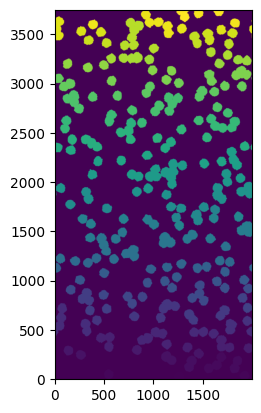

In [5]:
import matplotlib.pyplot as plt
lattice = np.zeros((height, width), dtype=np.int32)

acc_sites, cluster_labels, cluster_list = place_clusters_with_labels(
    width, height, avg_cluster_size,probabilities[-1], lattice)

plt.figure()
plt.imshow(cluster_labels,origin='lower')

In [6]:
for probability in probabilities:
    

    
#Simulate the system
 
    lattices,acceleration_sites,constraint_sites,snapshots,densities =eden_model_cascade_snapshots_parallel(width=width,height=height,n_iterations=n_iterations,snapshot_times=lin_t,
                                                               n_realizations=n_realizations,init_mode='flat',roughness_height=0,seed=42,
                                                               avg_cluster_size=avg_cluster_size,probability=probability ,acceleration_factor=5.0,
                                                               constraint_avg_cluster_size=0,constraint_prob=0,eden_sites=False)

    snapshots_avg=np.mean(snapshots,axis=0)
    snapshots_col.append(snapshots_avg)
    

9
38


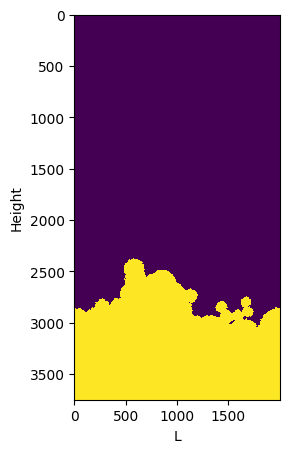

In [7]:
#### Visualize the growth
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(lattices[-1], interpolation='nearest')
plt.xlabel("L")
plt.ylabel("Height")


print(len(snapshots_col))
print(len(snapshots_avg))


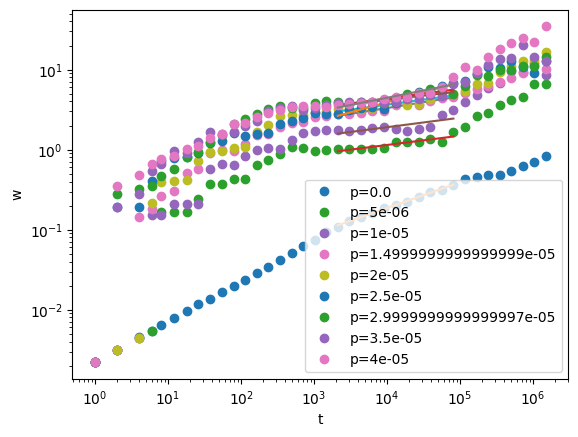

[0.0e+00 5.0e-06 1.0e-05 1.5e-05 2.0e-05 2.5e-05 3.0e-05 3.5e-05 4.0e-05]
[np.float64(0.3204496503688474), np.float64(0.1162581669421224), np.float64(0.11860209376468335), np.float64(0.14589730076492602), np.float64(0.1259941209753148), np.float64(0.24992396781802867), np.float64(0.12190817215129193), np.float64(0.1066805269303964), np.float64(0.1818889426948699)]


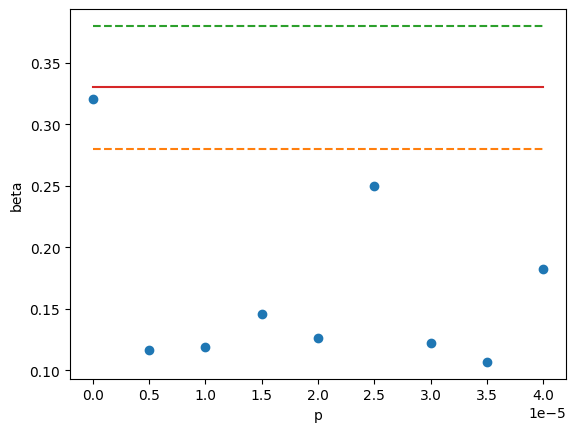

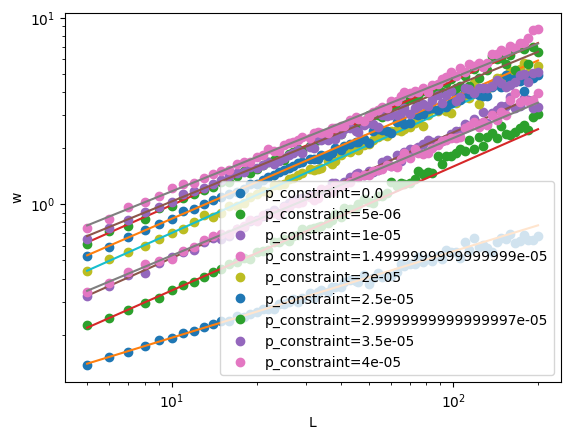

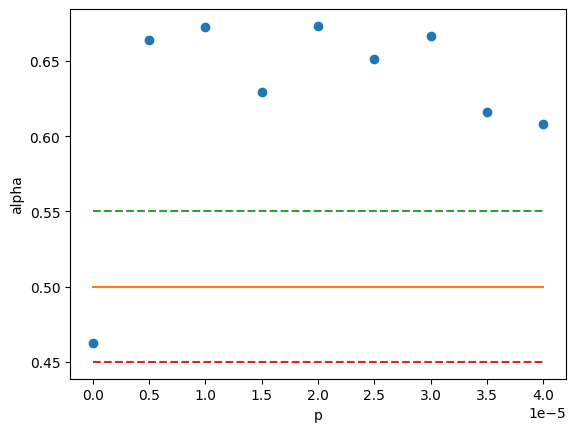

[np.float64(0.46268919506882333), np.float64(0.6638658998659054), np.float64(0.672581777825624), np.float64(0.6291024623591673), np.float64(0.6733464690982057), np.float64(0.6514348670817499), np.float64(0.666786702199836), np.float64(0.6159807751593914), np.float64(0.6082019613505822)]


In [8]:
#plot the exponents
import numpy as np
w_col=[]
w=[]




for i in range(len(probabilities)):
    for j in range((n_snapshots)-2):
        w.append(np.std(snapshots_col[i][j]))
    w_col.append(w)
    w=[]

   


res_col=[]

plt.figure()
for i in range(len(probabilities)):
    plt.loglog(lin_t[:],w_col[i][:],'o',label=f"p={probabilities[i]}")
    res=np.polyfit(np.log10(lin_t[19:30]),np.log10(w_col[i][19:30]),1)
    plt.loglog(lin_t[19:30],10**(np.log10((lin_t[19:30]))*res[0]+res[1]))
    res_col.append(res[0])
    plt.xlabel('t')
    plt.ylabel('w')

plt.legend()
plt.show()
print(probabilities)
print(res_col)

plt.figure()
plt.plot(probabilities[:],res_col[:],'o')
plt.plot(probabilities[:],0.28*np.ones((len(probabilities[:]),1)),'--')
plt.plot(probabilities[:],0.38*np.ones((len(probabilities[:]),1)),'--')
plt.plot(probabilities[:],0.33*np.ones((len(probabilities[:]),1)))
plt.xlabel('p')
plt.ylabel('beta')



def compute_avg_std_devs(array, num_points=10):
    """
    Compute the average standard deviation for logarithmically spaced section sizes l.
    
    Parameters:
    - array: 1D numpy array of length L
    - num_points: number of l values to generate (including endpoints)
    
    Returns:
    - l_values: array of l values (sorted)
    - avg_stds: array of average std devs for each l
    """
    L = len(array)
    l_min = 5
    l_max = L // 10
    
    if l_max < l_min:
        raise ValueError(f"L/4 ({l_max}) is less than l_min ({l_min}). Increase L or adjust l_min.")
    
    # Generate logarithmically spaced l values, unique and integer
    l_values = np.unique(np.logspace(np.log10(l_min), np.log10(l_max), num_points, dtype=int))
    
    avg_stds = []
    for l in l_values:
        stds = []
        for i in range(0,L - l + 1,l):
            sector = array[i:i+l]
            stds.append(np.std(sector))
        avg_stds.append(np.mean(stds))
    
    return l_values, np.array(avg_stds)

res_collection=[]
w_avg=[]





plt.figure()
for i in range(len(probabilities)):
    x = np.arange(len(snapshots_col[i][-1]))  # Spatial coordinates

    l,w=compute_avg_std_devs(snapshots_col[i][-1],num_points=100)
    
    plt.loglog(l,w,'o',label=f"p_constraint={probabilities[i]}")
    res=np.polyfit(np.log10(l[0:20]),np.log10(w[0:20]),1)
    res_collection.append(res[0])

    
    plt.loglog(l,10**(np.log10(l)*res[0]+res[1]))
plt.xlabel("L")
plt.ylabel('w')
plt.legend()
plt.show()




plt.figure()
plt.plot(probabilities[:],res_collection[:],'o')
plt.plot(probabilities[:],0.5*np.ones((len(probabilities[:]),1)))
plt.plot(probabilities[:],0.55*np.ones((len(probabilities[:]),1)),'--')
plt.plot(probabilities[:],0.45*np.ones((len(probabilities[:]),1)),'--')
plt.xlabel("p")
plt.ylabel('alpha')
plt.show()

print(res_collection)

